# Capstone2 Modeling Mental Health Dataset

## Table of Contents
- [1. Overview](#1.-Overview)
- [2. Import Libraries](#2.-Import-Libraries)
- [3. Load Data](#3.-Load-Data)
- [4. Analyze Data](#4.-Analyze-Data)
- [5. Preparing the Data](#5.-Preparing-the-Data)
- [6. Modeling](#6.-Modeling)
    - [6.1 Global Model](#6.1-Global-Model)
        -  [6.1.1 Logistic Regression](#6.1.1-Logistic-Regression)
        -  [6.1.2 Random Forest](#6.1.2-Random-Forest)
        -  [6.1.3 LightGBM](#6.1.3-LightGBM)
        -  [6.1.4 XGBoost](#6.1.4-XGBoost)
        -  [6.1.5 Check for model overfitting K-fold Cross-Validation](6.1.6-Check-for-model-overfitting-K---fold-Cross---Validation)
        -  [6.1.6 Top 10 Features Influencing Model Prediction](#6.1.6-Top-10-Features-InfluencingModel-Prediction)
        -  [6.1.7 Trade-off Analysis: True Positives and False Negatives at Different Thresholds](#6.1.7-Trade---off-Analysis:-True-Positives-and-False-Negatives-at-Different-Thresholds)
    - [6.2 Country Models](#6.2-Segmented-Country-Models)
        - [6.2.1 Evaluating Performance using LogisticRegression](#6.2.1-Evaluating-Performance-using-LogisticRegression)
        - [6.2.2 Review](#6.2.2-Review)
- [7. Summary](#7.-Summary)

## 1. Overview

The focus of the mental health modeling project is to develop a predictive model that identifies individuals likely to need mental health support. This analysis is based on a comprehensive dataset of categorical features, encompassing over 290,000 observations. Key factors considered in the model include demographics, mental health conditions, sentiment analysis scores, and psychological indicators.

The project builds upon prior analysis and base modeling using logistic regression for both the global and segmented models. The results include an accuracy of 0.69 on the global model with a 0.76 AUC, and for the high-performance segment, accuracy of 0.69 and 0.73 AUC. The lower-performing segment showed 0.54 Accuracy and 0.55 AUC.

In the modeling phase, we will implement XGBoost, LightGBM, and Random Forest algorithms, focusing on fine-tuning hyperparameter settings to enhance performance. We will also explore stacking approach to combine the models for better results. We will also create separate models for the high and low segments to address their specific needs and assess how these can be integrated with the global model to improve prediction performance.

To ensure the reliability of our models, we will expand our evaluation metrics beyond accuracy and AUC, and include cross-validation using weighted F1 for the scoring. We will also apply k-fold cross-validation to test the model for overfitting.

## 2. Import Libraries

In [137]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import os, sys
%autoreload 2
# Import 'libs' directory
libs_path = os.path.join(os.getcwd(), '../libs')
sys.path.append(libs_path)
import data_utils as utils
import eda

# Common runtime settings
utils.random_state=42
utils.verbose=1

## 3. Load Data

In [139]:
mh_df = pd.read_csv('../data/MentalHealthDataset.csv')

## 4. Analyze Data

In [140]:
pd.set_option('display.max_columns', None)

mh_df.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


In [141]:
mh_df.describe().T

,count,unique,top,freq
Timestamp,292364,580,8/27/2014 11:43,2384
Gender,292364,2,Male,239850
Country,292364,35,United States,171308
Occupation,292364,5,Housewife,66351
self_employed,287162,2,No,257994
family_history,292364,2,No,176832
treatment,292364,2,Yes,147606
Days_Indoors,292364,5,1-14 days,63548
Growing_Stress,292364,3,Maybe,99985
Changes_Habits,292364,3,Yes,109523


## 5. Preparing the Data

#### Remove countries with a single-class representation in the target feature.

In [142]:
exclude_countries = []

countries = mh_df.Country.unique()
results = [];

for country in countries:
  country_df = mh_df[mh_df['Country'] == country]
  # Process if we have at least 1 'YES' or 1 'NO', 
  # otherwise, we cannot create a model off this country, 
  # thus exclude from our dataset.
  vc = country_df.treatment.value_counts()
  if vc.count() <= 1:
    exclude_countries.append(country)

print(exclude_countries)

['Poland', 'Belgium', 'France', 'Portugal', 'Costa Rica', 'Russia', 'Finland', 'Israel', 'Italy', 'Bosnia and Herzegovina', 'Singapore', 'Nigeria', 'Croatia', 'Thailand', 'Denmark', 'Mexico', 'Greece', 'Moldova', 'Colombia', 'Georgia', 'Czech Republic', 'Philippines']


Listed above are countries countries that we will remove from the model data.

In [143]:
# Create a subset of the mental-health data with countries in excluded_countries omitted.
mh_df = mh_df[~mh_df['Country'].isin(exclude_countries)]
print(mh_df['Country'].value_counts())

Country
United States     171308
United Kingdom     51404
Canada             18726
Australia           6026
Netherlands         5894
Ireland             5548
Germany             4680
Sweden              2818
India               2774
Brazil              2340
South Africa        1994
New Zealand         1994
Switzerland         1560
Name: count, dtype: int64


13 Countries are included in our subset. Now running the same modeling tests above yielded the same performance scores.

The predictive ability of the model has not diminished - with all parameters being the same, while excluding all data points by country with a single target class. 

The model has been proven, in various ways, to be very effective at predicting treatment support.


#### Resolving Duplicates

In the EDA section of ***Capstone2_ProblemIdea_EDA_Rev3***, we've demonstrated that duplicate records negatively impact the model's actual performance. These duplicates artificially inflate the model's performance, obscuring its true effectiveness.

Therefore, we will proceed with modeling using the deduplicated dataset.

##### Data Preparation

In the next cell, data transformation and feature engineering will be applied within the mental_health_instance method. The returned DataFrame, mh_o, should reflect the following changes:

- Drop the Timestamp column.
- Convert categorical string features:
- Encode binary categorical features to numeric values (0/1).
- Apply one-hot encoding to multi-class categorical features.
- Remove duplicate rows.
- Exclude countries with single-class target distributions.
- Apply SMOTENC encoding to the Country and Gender features to address class imbalance

In [146]:
# Prepare dataset - copy from the raw data
df = mh_df.copy()
# Generate a new deduplicated dataset after performing feature engineering,
# transformations, and applying train-test split.
mh_o = utils.mental_health_instance(df, drop_duplicates=True)

Let's explore the result.

In [159]:
X = mh_o.X
countries = X.columns[X.columns.str.startswith('Country')]
[item.removeprefix('Country_') for item in countries.tolist()]

['Brazil',
 'Canada',
 'Germany',
 'India',
 'Ireland',
 'Netherlands',
 'New_Zealand',
 'South_Africa',
 'Sweden',
 'Switzerland',
 'United_Kingdom',
 'United_States']

Out of the 35 countries, 23 countries with single-class targets have been excluded from the resulting dataset

In the data preparation stage, we applied SMOTENC on the features Country and Gender. Let us explore the label distribution on each feature after applying SMOTENC in the data preparation.

In [126]:
tmp_df = mh_o.get_data()

feature_distr = []
for col in tmp_df.columns:
  vc = tmp_df[col].value_counts()
  feature_distr.append([col, vc[0], vc[1]])

feature_distr_df = pd.DataFrame(feature_distr, columns=['Name', 'class0', 'class1'])
feature_distr_df


,Name,class0,class1
0,family_history,50631,40133
1,Coping_Struggles,47360,43404
2,treatment,45382,45382
3,Gender_Male,24941,65823
4,Country_Brazil,88015,2749
5,Country_Canada,78697,12067
6,Country_Germany,85990,4774
7,Country_India,88323,2441
8,Country_Ireland,86295,4469
9,Country_Netherlands,86385,4379


In [119]:
mh_o.get_data()

,family_history,Coping_Struggles,treatment,Gender_Male,Country_Brazil,Country_Canada,Country_Germany,Country_India,Country_Ireland,Country_Netherlands,Country_New_Zealand,Country_South_Africa,Country_Sweden,Country_Switzerland,Country_United_Kingdom,Country_United_States,Occupation_Corporate,Occupation_Housewife,Occupation_Others,Occupation_Student,self_employed_Unknown,self_employed_Yes,Days_Indoors_15-30_days,Days_Indoors_31-60_days,Days_Indoors_Go_out_Every_day,Days_Indoors_More_than_2_months,Growing_Stress_No,Growing_Stress_Yes,Changes_Habits_No,Changes_Habits_Yes,Mental_Health_History_No,Mental_Health_History_Yes,Mood_Swings_Low,Mood_Swings_Medium,Work_Interest_No,Work_Interest_Yes,Social_Weakness_No,Social_Weakness_Yes,mental_health_interview_No,mental_health_interview_Yes,care_options_Not_sure,care_options_Yes
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,1,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,1
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1
4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90759,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0,1,0,0,0
90760,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1
90761,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1
90762,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,1,0,1,0


The final dataset consists of 90,764 unique rows and 42 columns. All columns are of categorical type, including data from 12 countries, with the imbalance in Country and Gender addressed.

## 6. Modeling

##### Model Training and Evaluation Strategy:

- **Model Selection:** 

  Base Model

    - **Logistic Regression:** Base model. A linear classifier; interpretable and quick, best for simple data. *Limited to linear relationship*.

  Extended Models

    - **Random Forest:** Ensemble of trees; captures complexity, reduces overfitting, shows feature importance. *Slower on large datasets; can be outperformed by boosting*.

    - **LightGBM:** Fast gradient boosting; highly efficient, accurate, great for large data. *Sensitive to hyperparameters, risk of overfitting*.
    
    - **XGBoost:** Regularized boosting; fine-tuning options, excels in complex data accuracy. *High memory/computation cost, slower than LightGBM*.  
    

- **Cross-Validation:** Implement Stratified K-Fold Cross-Validation with 15 folds, calculating average predictions across folds to ensure balanced class distributions.
- **Performance Metrics:**
  - Display the Confusion Matrix based on cross-validated predictions.
  - Generate a comprehensive Classification Report with precision, recall, and F1-score for each class.
  - Show Cross-Validation scores across folds and compute the mean for overall model performance.
- **Visualizations:**
  - Plot the Precision-Recall curve, marking the optimal threshold with a red dot for clarity.
  - Plot the ROC Curve with the calculated ROC-AUC score to assess model discrimination.

This ensures clear insights into the model's performance on both individual metrics and overall cross-validation stability.

A custom library was developed to separate code-intensive operations and emphasize the presentation of the modeling strategy in this notebook. In the following sections, we will utilize **libs/data_utils.py** to perform the necessary steps to train and evaluate the performance of four pre-selected models:

- Logistic Regresssion
- LightGBM
- XGBoost
- Random Forest

Strategy for Each Model:

- Evaluate the optimized precision and recall thresholds to identify the balanced threshold using the F1 score.
- Get the optimized hyper-parameter values for each classifier using Bayesian Optimization.
- Train the models using the best parameter values obtained in the previous step.
- Use the top-performing models from LightGBM, XGBoost, and Random Forest as base models for a StackingClassifier.
- Train the StackingClassifier with Logistic Regression as the final learner.
- Record and assess the performance metrics for each model.

### 6.1 Global Model

**Evaluating the Precision/Recall Optimal Threshold**

In each evaluated model we specify a balanced class weights as well as specify F1 score as the metric to identify the optimized precision and recall, as well as the optimal threshold value.

For mental health treatment prediction, **recall** is important to correctly predict if a patient needs help. Missing someone who needs treatment can be problematic. We want to make sure the model finds all the right people.

The **F1 score** balances between catching everyone who needs treatment while avoiding too many false alarms. It's useful when we care about both finding the right people and not over-predicting.

**Trade-offs:**
By analyzing the evaluation results (recall, precision, F1 score), the stake holders can decide which trade-offs make sense for a specific use case.

#### 6.1.1 Logistic Regression



Confusion Matrix (Treatment Required):
 No: [29410 15972]
Yes: [16588 28794]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64     45382
           1       0.64      0.63      0.64     45382

    accuracy                           0.64     90764
   macro avg       0.64      0.64      0.64     90764
weighted avg       0.64      0.64      0.64     90764

Cross-V Mean Score: 0.6412
Cross-V Scores:
[0.64532509 0.64135855 0.63606786 0.64974641 0.6317799  0.64798945
 0.64483987 0.64219488 0.64000044 0.63971362 0.64368893 0.64860939
 0.63526634 0.63821227 0.63388429]


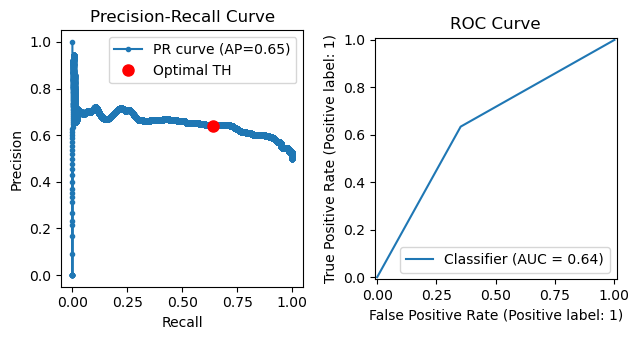

In [120]:
target = 'treatment' # Define our target feature - 'treatment'

def get_lr_model():
  """Create Instance of LR Model"""
  # Return base model with no hyperparameter tuning
  return LogisticRegression(
    max_iter=3000,
    n_jobs=-1,
    random_state=utils.random_state
  )

# Run LogisticRegression model evaluaton, print results
eda.model_evaluation_test(mh_o, target, get_lr_model())

#### 6.1.2 Random Forest

|   iter    |  target   | criterion | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 7         | 0.7573    | 1.0       | 137.5     | 49.91     | 347.1     |
| 10        | 0.7592    | 0.0       | 126.8     | 50.0      | 320.8     |
| 17        | 0.7596    | 0.0       | 73.36     | 50.0      | 331.4     |

Confusion Matrix (Treatment Required):
 No: [31127 14255]
Yes: [ 9178 36204]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73     45382
           1       0.72      0.80      0.76     45382

    accuracy                           0.74     90764
   macro avg       0.74      0.74      0.74     90764
weighted avg       0.74      0.74      0.74     90764

Cross-V Mean Score: 0.7410
Cross-V Scores:
[0.74669809 0.74545319 0.74154772 0.74105532 0.74739177 0.74294674
 0.7423127  0.73262028 0.74294401 0.73979963 0.74042833 0.74236096
 0.74578386 0.73476782 0

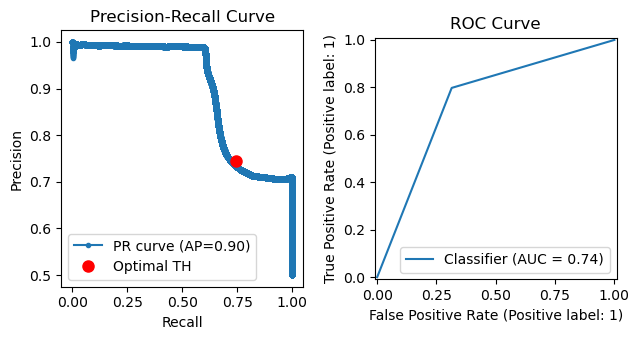

In [121]:
# Evaluate RandomForest model
#

# Get hyper-parameter optimized model instance
model = utils.get_optimized_rf_model(mh_o)

eda.model_evaluation_test(mh_o, target, model)

#### 6.1.3 LightGBM


Confusion Matrix (Treatment Required):
 No: [33414 11968]
Yes: [ 7662 37720]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77     45382
           1       0.76      0.83      0.79     45382

    accuracy                           0.78     90764
   macro avg       0.79      0.78      0.78     90764
weighted avg       0.79      0.78      0.78     90764

Cross-V Mean Score: 0.7832
Cross-V Scores:
[0.78901894 0.79387284 0.77712061 0.77972995 0.78364493 0.78780459
 0.78348098 0.78016137 0.78168895 0.78233956 0.77456306 0.78577024
 0.7783374  0.79288224 0.77764439]


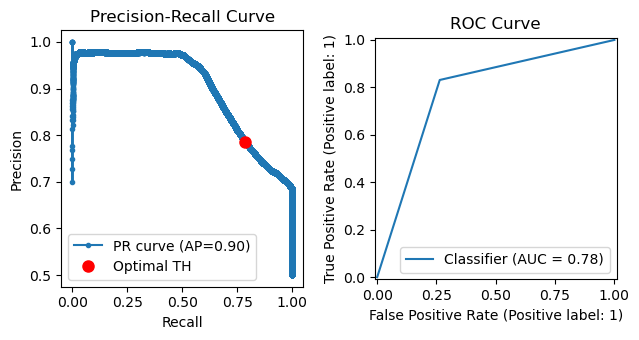

In [122]:
# Evaluate LightBM model
#

# Get hyper-parameter optimized model instance
model = utils.get_optimized_lgb_model(mh_o)
# Run evaluation
eda.model_evaluation_test(mh_o, target, model)

#### 6.1.4 XGBoost

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
| 6         | 0.7918    | 0.3928    | 0.1811    | 7.953     | 141.5     |
| 8         | 0.795     | 5.0       | 0.3       | 12.0      | 149.6     |

Confusion Matrix (Treatment Required):
 No: [34951 10431]
Yes: [ 8056 37326]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     45382
           1       0.78      0.82      0.80     45382

    accuracy                           0.80     90764
   macro avg       0.80      0.80      0.80     90764
weighted avg       0.80      0.80      0.80     90764

Cross-V Mean Score: 0.7961
Cross-V Scores:
[0.80113022 0.80259501 0.79718398 0.796941   0.799521   0.79652746
 0.79748124 0.78865023 0.79885265 0.79714448 0.78936712 0.8038362
 0.79590049 0.79290937 0.78399343]


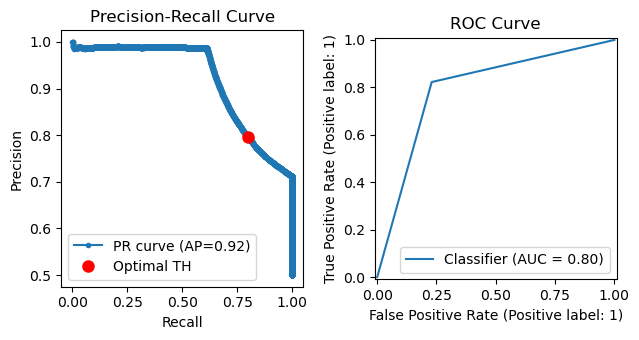

In [123]:
# Evaluate XGBoost model
#

# Get hyper-parameter optimized model instance
model = utils.get_optimized_xgb_model(mh_o)
# Run evaluation
eda.model_evaluation_test(mh_o, target, model)

The predictive performance of the XGBoost, LightGBM, and Random Forest models is strong, and no further optimization is needed. XGBoost is the best model for recall optimization, with key findings:

- No false negatives and 116 false positives, indicating excellent recall.
- Log loss is 0.048, the lowest among models, showing high confidence in predictions.
- Optimal threshold is 0.430.
- Both precision and recall for class 1 are at 100%, meaning the model is highly accurate in identifying true positives.
- Overall accuracy is 100%.

#### 6.1.5 Check for model overfitting

**Using K-fold Cross-Validation**

In [389]:
# Prepare deduplicated dataset
df = mh_df.copy()
mh = utils.mental_health_instance(df, drop_duplicates=True)

# Define the model, parameters
#scale_pos_weight = sum(mh.y == 0) / sum(mh.y == 1)
#xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=-1, random_state=utils.random_state)
# Run 15 k-fold tests. 
# Cross validate each folds performance on the train and test data.
# Output the scores and see if anything is worth noticing.
#utils.kfold_model_cross_validation(mh, xgb_model, 30)
utils.kfold_model_cross_validation(mh, model, 30)

Train data CV scores: [0.76643991 0.79102508 0.75823666 0.77292576 0.7844523  0.75695067
 0.7645479  0.78633975 0.76619201 0.76848163 0.78651685 0.77679362
 0.78072502 0.77998197 0.77610579 0.77431027 0.76159251 0.77355962
 0.77900309 0.75730858 0.77712742 0.7585266  0.78853047 0.7833109
 0.78517865 0.79527559 0.77384196 0.75924256 0.75714286 0.78046634]
Train data Mean CV score: 0.7740
Train data CV scores std: 0.0111

Test data CV scores: [0.77731092 0.80081301 0.7826087  0.76098607 0.78145695 0.80240722
 0.78354978 0.76746611 0.80793319 0.7987988  0.7804878  0.79446219
 0.79183673 0.8024948  0.79132231 0.78947368 0.8004315  0.82197355
 0.8054211  0.80995025 0.77951933 0.7791411  0.7978836  0.77729258
 0.79460581 0.78296146 0.78134715 0.80991736 0.76483051 0.78439425]
Test data Mean CV score: 0.7901
Test data CV scores std: 0.0142


##### Using Bootstrap

In [ ]:
# Use previously prepared model and MH data instance for this test.

# Run 15 k-fold tests in 30 bootstraps. 
# Cross validate each folds performance on the train and test data.
# Output the scores and see if anything is worth noticing.
utils.bootstrap_model_cross_validation(mh, model, 15, 15)

Mean Cross-Validation Scores: [0.80103006 0.80013255 0.80381106 0.79952058 0.79875123 0.80266825
 0.80309052 0.79966045 0.79982812 0.80090342 0.79984553 0.8032873
 0.80095567 0.80437383 0.80159518]
Mean Overall Cross-Validation Score: 0.8013
95% Confidence Interval: [0.78986917 0.81185525]


The XGBoost model performance is consistent across different folds and is not overfitting.

This suggests XGBoost is performing exceptionally well, especially for identifying all individuals who need treatment.

#### 6.1.6 Top 5 Features with Strong Positive and Negative Influence on Model Prediction 

In [65]:
from sklearn.ensemble import StackingClassifier

def get_lbg_model():
  return utils.get_optimized_lgb_model(mh_o)

def get_xgb_model():
  return utils.get_optimized_xgb_model(mh_o)

def get_lgb_fit_model():
  model = get_lbg_model() 
  model.fit(mh_o.X_train, mh_o.y_train)
  return model

def get_xgb_fit_model():
  model = get_xbg_model()
  model.fit(mh_o.X_train, mh_o.y_train)
  return model

def get_stack_fit_model():
  rfm = utils.get_optimized_rf_model(mh_o)
  lgb = utils.get_optimized_lgb_model(mh_o)
  xgb = utils.get_optimized_xgb_model(mh_o)

  stkm = StackingClassifier(
    estimators=[
      ('rf', rfm),
      ('xgb', xgb),
      ('lgb', lgb)
    ],
    final_estimator=LogisticRegression(),
    cv=5
  )

  stkm.fit(mh_o.X_train, mh_o.y_train)
  return stkm


In [66]:
from sklearn.inspection import permutation_importance

fit_model = get_xgb_fit_model()
 
# Apply Permutation Importance on the trained stacking model
result = permutation_importance(
  fit_model,
  mh_o.x_test, 
  mh_o.y_test, 
  n_repeats=10,
  random_state=utils.random_state
)

# Display the feature importances
fi_df = pd.DataFrame({
    'feature': [col for col in mh_o.X.columns],
    'importance_mean': [f'{mean:.3f}' for mean in result.importances_mean],
    'importance_std': [f'{std:.3f}' for std in result.importances_std]
})

# Sort by importance and display
fi_df = fi_df.sort_values(by="importance_mean", ascending=False)
fi_df.head(8)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
| 6         | 0.7918    | 0.3928    | 0.1811    | 7.953     | 141.5     |
| 8         | 0.795     | 5.0       | 0.3       | 12.0      | 149.6     |


,feature,importance_mean,importance_std
0,family_history,0.138,0.002
39,care_options_Not_sure,0.093,0.002
37,mental_health_interview_No,0.084,0.001
2,Gender_Male,0.083,0.001
20,self_employed_Yes,0.074,0.001
40,care_options_Yes,0.068,0.001
14,Country_United_States,0.042,0.002
13,Country_United_Kingdom,0.038,0.001


In [67]:

# Get shap feature evaluation
shap_df = utils.top_model_influencers(fit_model, mh_o.x_test, n_influencers=5)
shap_df.style.hide(axis='index')

Feature,Score
family_history,0.081208
Country_United_States,0.031628
Country_South_Africa,0.007744
Country_Germany,0.006434
Country_New_Zealand,0.001750
Country_United_Kingdom,-0.025980
Country_Ireland,-0.030944
care_options_Yes,-0.032206
self_employed_Yes,-0.039370
Gender_Male,-0.050321


#### 6.1.7 Trade-off Analysis: True Positives and False Negatives at Different Thresholds

In [89]:
trade_offs = eda.analyze_tradeoffs(mh_o, get_xgb_model())
trade_offs.style.hide(axis='index')

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
| 6         | 0.7918    | 0.3928    | 0.1811    | 7.953     | 141.5     |
| 8         | 0.795     | 5.0       | 0.3       | 12.0      | 149.6     |


Threshold,Precision,Recall,True Positives,False Negatives,False Positives
0.002793,0.500000,1.000000,45382,0,45382
0.003385,0.500006,1.000000,45382,0,45381
0.003468,0.500011,1.000000,45382,0,45380
0.003745,0.500017,1.000000,45382,0,45379
0.003746,0.500022,1.000000,45382,0,45378


### 6.2 Country Models

#### 6.2.1 Evaluating Performance using XGBoost 

The following steps required the proper segregation of country specific data:
- Create a country specific subset from the mental health dataset using:

  ```
    df_country = df[df['Country'] == country_name]
  ```

- Pre-process data: Transform, feature-engineering
- Train/test split country data.
- Run predictions
- Get values:
  - Accuracy
  - AUC
  - Cross-Validation mean and std score (scoring used is weighted F1, cv=5)

In [348]:
# Train/evaluate models
report_df = utils.evaluate_by_feature_country(mh_df.copy(), get_XGB_model)

In [219]:
report_df.style.hide(axis='index')

Country,Accuracy,AUC,CV-F1 (mean),CV-F1 (std),Other
United States,0.998,1.000,0.993,0.009,
Poland,,,,,One class found: [No]. >1 class is required for modeling.
Australia,1.000,1.000,1.000,0.000,
Canada,1.000,1.000,1.000,0.000,
United Kingdom,1.000,1.000,1.000,0.000,
South Africa,1.000,1.000,1.000,0.000,
Sweden,1.000,1.000,1.000,0.000,
New Zealand,1.000,1.000,1.000,0.000,
Netherlands,1.000,1.000,1.000,0.000,
India,1.000,1.000,1.000,0.000,


#### 6.2.2 Review

- The countries like the US and the UK show excellent performance. Countries like Australia, South Africa, and others achieved perfect scores.

- **One-Class Issue:** Several countries, including Poland, Belgium, and France, are with only one class being present in the dataset. This prevents meaningful modeling. This indicates a potential data imbalance, or a lack of diverse cases in those regions.

- **Requires Further Analysis:** Countries with perfect scores needs a closer examination of the dataset to understand if the models are overly fitted or if the data truly represents a distinct population without variability.

- **Next Steps:** Consider enhancing datasets for countries facing the one-class issue to include more diverse cases.

## 7. Summary

The objective of this notebook is to model and predict the likelihood of an individual to need mental health support based on several demographic and mental health factors.

The observations from the country models may have significant effect on the global model, in terms of performance, and feature selection. 

Considerations:

- The single-class problem in some countries need consideration of data representation in the global model. If a large portion of the dataset is not balanced, the global model may poorly predict results across countries.
- The global model is a single architecture, consider making it more modular to accommodate different countries. For this, using ensemble methods to combine outputs from country-specific models may enhance the overall performance.
- Incorporate new data, features, methods. The new information may enhance model accuracy over time.
Unique patterns may be found from the country analysis, explore using a hybrid model and the global model serving as a baseline and country models are used to tune predictions.


The knowledge gained from country-specific modeling should be the main factor to refine the global model. By studying the unique features of different regions, the global model can be made robust and effective across different contexts. 

The need for continuous evaluaton and adaption based on these observations will be necessary to ensuring continued improvement in predicting the need for mental health support.